<a href="https://colab.research.google.com/github/11330344/Thesis-Project/blob/main/trainingandpreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split

# Load the FER2013 dataset (replace with your actual file path)
df = pd.read_csv('/content/drive/MyDrive/Thesis2024/fer2013.csv')

# Extract pixel values and labels
pixels = df['pixels'].apply(lambda x: np.array(x.split(), dtype='float32'))
labels = df['emotion']

# Normalize pixel values
pixels /= 255.0

# Reshape pixel arrays to (48, 48, 1)
X_train = np.stack(pixels.values).reshape(-1, 48, 48, 1)
Y_train = labels.values


Mounted at /content/drive


In [ ]:
# Split the data into training, validation, and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))  # 7 emotions: anger, disgust, fear, happiness, sadness, surprise, neutral

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_split=0.2)


Epoch 1/100
359/359 [==============================] - 8s 11ms/step - loss: 1.7894 - accuracy: 0.3232 - val_loss: 1.9031 - val_accuracy: 0.1811
Epoch 2/100
359/359 [==============================] - 4s 10ms/step - loss: 1.5206 - accuracy: 0.4061 - val_loss: 1.5150 - val_accuracy: 0.4108
Epoch 3/100
359/359 [==============================] - 4s 10ms/step - loss: 1.4360 - accuracy: 0.4396 - val_loss: 1.4492 - val_accuracy: 0.4598
Epoch 4/100
359/359 [==============================] - 3s 9ms/step - loss: 1.3479 - accuracy: 0.4731 - val_loss: 1.3953 - val_accuracy: 0.4747
Epoch 5/100
359/359 [==============================] - 3s 9ms/step - loss: 1.2955 - accuracy: 0.4978 - val_loss: 1.3597 - val_accuracy: 0.4725
Epoch 6/100
359/359 [==============================] - 4s 11ms/step - loss: 1.2324 - accuracy: 0.5210 - val_loss: 1.2757 - val_accuracy: 0.5216
Epoch 7/100
359/359 [==============================] - 3s 10ms/step - loss: 1.1872 - accuracy: 0.5418 - val_loss: 1.3292 - val_accuracy: 0

In [5]:
# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 21, 21, 64)        256       
 chNormalization)                                                
                                                        

225/225 [==============================] - 2s 6ms/step


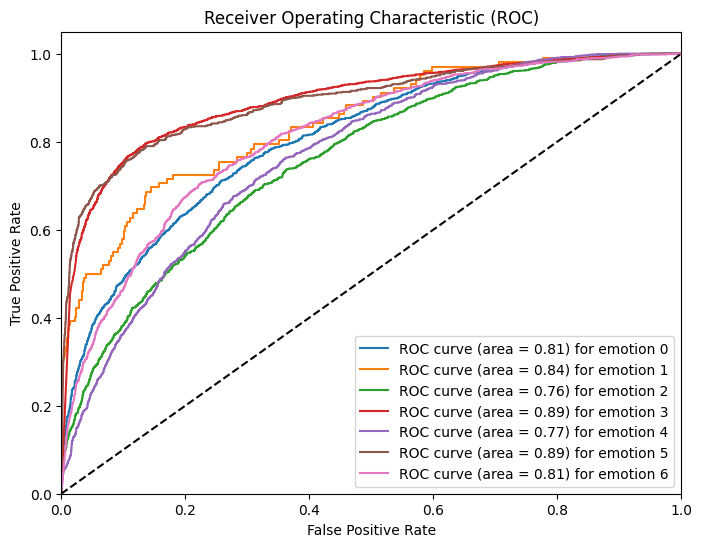

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Convert integer labels to one-hot encoded format
lb = LabelBinarizer()
Y_test_binary = lb.fit_transform(Y_test)
# Get predicted probabilities for each class
Y_pred_prob = model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):  # assuming there are 7 classes
    fpr[i], tpr[i], _ = roc_curve(Y_test_binary[:, i], Y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(7):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for emotion %d' % (roc_auc[i], i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()




In [ ]:
# Get predicted probabilities for each class
Y_pred_prob = model.predict(X_test)


threshold = 0.5
Y_pred_binary = (Y_pred_prob > threshold).astype(int)

# Convert integer labels to one-hot encoded format
Y_test_onehot = label_binarize(Y_test, classes=np.arange(7))  # assuming 7 classes

# Calculate F1 score using the new binary predictions and one-hot encoded labels
f1 = f1_score(Y_test_onehot, Y_pred_binary, average='weighted')

print("F1 score:", f1)


225/225 [==============================] - 1s 2ms/step
F1 score: 0.5321316078585239


In [ ]:
import numpy as np
from sklearn.metrics import precision_score
from sklearn.preprocessing import label_binarize

# Get predicted probabilities for each class
Y_pred_prob = model.predict(X_test)

# Choose a new threshold
new_threshold = 0.5

# Apply the new threshold to convert probabilities to binary predictions
Y_pred_binary = np.where(Y_pred_prob >= new_threshold, 1, 0)

# Convert integer labels to one-hot encoded format
Y_test_onehot = label_binarize(Y_test, classes=np.arange(7))  # assuming 7 classes

# Calculate precision using the new binary predictions and one-hot encoded labels
precision = precision_score(Y_test_onehot, Y_pred_binary, average='weighted')

print("Precision with new threshold:", precision)


225/225 [==============================] - 1s 2ms/step
Precision with new threshold: 0.5534174835916847


225/225 [==============================] - 1s 4ms/step


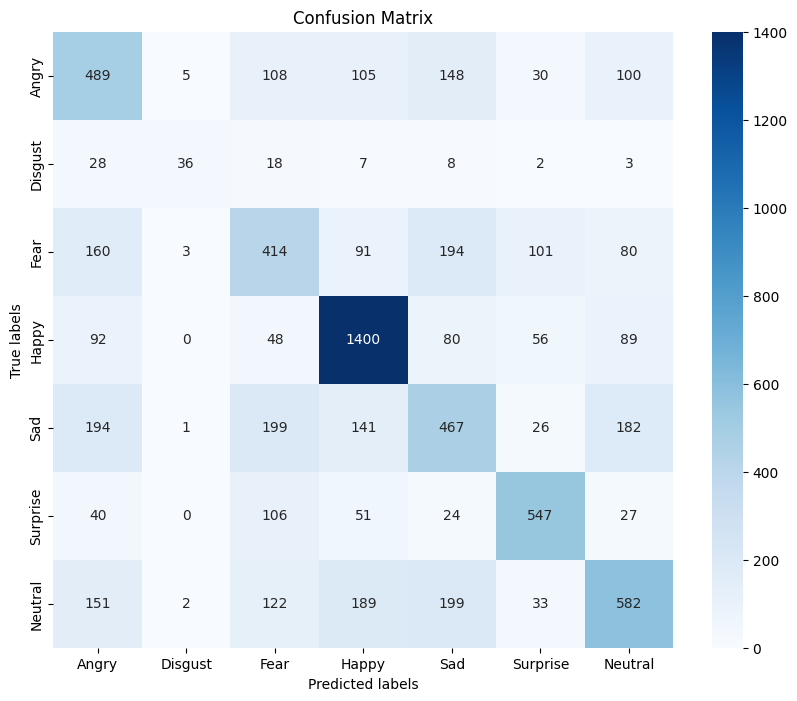

In [ ]:
# Get predicted probabilities for each class
Y_pred_prob = model.predict(X_test)

# Convert probabilities to predicted labels
Y_pred = np.argmax(Y_pred_prob, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
Emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=Emotions, yticklabels=Emotions)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



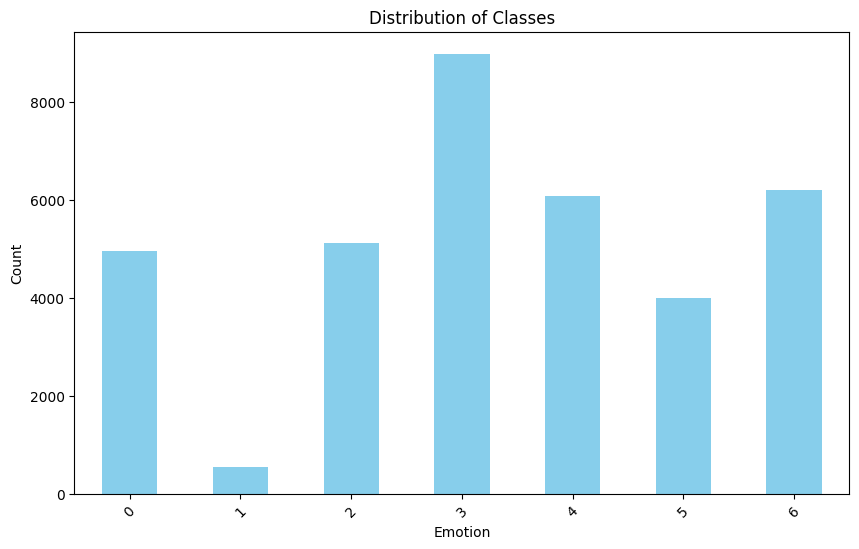

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a pandas DataFrame 'df' with a column 'emotion' representing class labels
class_counts = df['emotion'].value_counts()

# Specify the order of classes
class_order = sorted(class_counts.index)  # Assuming the class labels are numeric

# Plot the distribution of classes
plt.figure(figsize=(10, 6))
class_counts[class_order].plot(kind='bar', color='skyblue')
plt.title('Distribution of Classes')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


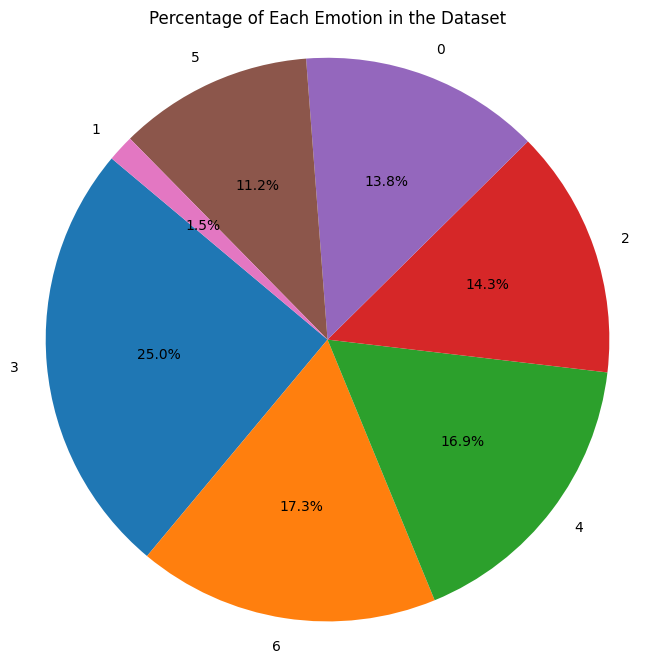

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a pandas DataFrame 'df' with emotion labels
# Count the occurrences of each emotion
emotion_counts = df['emotion'].value_counts()

# Plotting
plt.figure(figsize=(8, 8))
plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Percentage of Each Emotion in the Dataset')
plt.show()


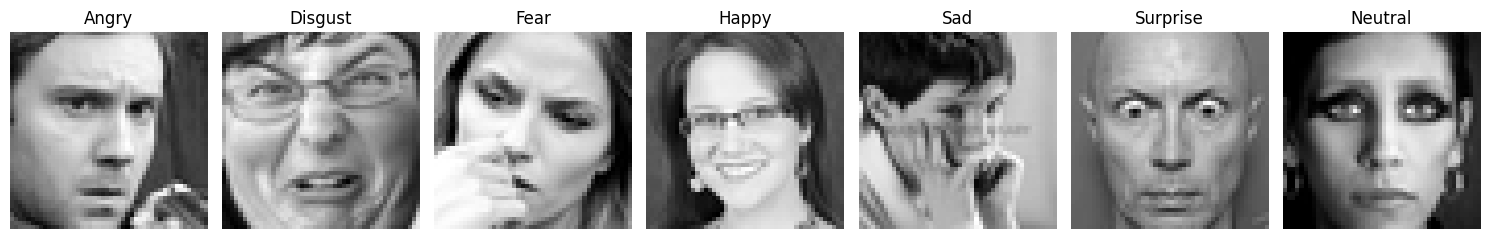

In [ ]:
import matplotlib.pyplot as plt

# Define emotions and their corresponding labels
emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# Create a figure with subplots for each emotion
fig, axes = plt.subplots(1, len(emotions), figsize=(15, 3))

# Iterate over each emotion and find a sample for that emotion
for i, emotion in enumerate(emotions):
    # Find the first sample with the current emotion label
    sample = df[df['emotion'] == i].iloc[0]

    # Convert the pixel values to an array and reshape it to the original image dimensions
    pixels = np.array(sample['pixels'].split(), dtype='int').reshape(48, 48)

    # Display the image in the corresponding subplot
    axes[i].imshow(pixels, cmap='gray')
    axes[i].set_title(emotion)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Get predicted labels
Y_pred = model.predict(X_test)
Y_pred_labels = np.argmax(Y_pred, axis=1)

# Generate classification report
class_report = classification_report(Y_test, Y_pred_labels)

print("Classification Report:\n", class_report)


225/225 [==============================] - 1s 4ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.50      0.46       985
           1       0.77      0.35      0.48       102
           2       0.41      0.40      0.40      1043
           3       0.71      0.79      0.75      1765
           4       0.42      0.39      0.40      1210
           5       0.69      0.69      0.69       795
           6       0.55      0.46      0.50      1278

    accuracy                           0.55      7178
   macro avg       0.57      0.51      0.53      7178
weighted avg       0.55      0.55      0.54      7178



In [ ]:
model.save('/content/drive/MyDrive/Thesis2024/fer2013_Model.h5')